### This notebook will walk you through how to build a lipid bilayer with OpenFF

In [1]:
# Import all dependencies 
# from io import StringIO
# from typing import Iterable
import numpy as np
# import matplotlib.pyplot as plt

# from rdkit import Chem
# import MDAnalysis as mda
from MDAnalysis.analysis import distances
from openff.toolkit import ForceField, Molecule, Topology
# from openff.toolkit.utils.toolkits import OpenEyeToolkitWrapper

from openff.units import Quantity, unit
# from openmm import unit as openmm_unit
from openff.interchange import Interchange
from openff.toolkit.utils.nagl_wrapper import NAGLToolkitWrapper #assign charges with NAGL

import nglview
import mdtraj
import sys
import os

scripts_path = os.path.join(os.getcwd(), 'scripts')
sys.path.insert(0, scripts_path)

from pull import pullLipid
import BuildLipid

/home/julianne/miniconda3/envs/openff_clone/lib/python3.11/site-packages/Bio/__init__.py:138: BiopythonWarning: You may be importing Biopython from inside the source tree. This is bad practice and might lead to downstream issues. In particular, you might encounter ImportErrors due to missing compiled C extensions. We recommend that you try running your code from outside the source tree. If you are outside the source tree then you have a setup.py file in an unexpected directory: /home/julianne/miniconda3/envs/openff_clone/lib/python3.11/site-packages
  warnings.warn(


### Build lipid and water from smiles string and use OpenFF Interchange to parameterize

Available lipids are located in BuildLipid module, which constructs lipids in a modular fashion {sn1} + {hg} + {sn2}.

Available headgroups:  ['PA', 'PC', 'PE', 'PG', 'PP', 'PS']
Available tailgroups:  ['DC', 'DD', 'DL', 'DM', 'DO', 'DP', 'DR', 'DS', 'PE', 'PL', 'PO', 'PS', 'SL', 'SO']
Available sterols:  ['aldosterone', 'beta-Sitosterol', 'beta-estradiol', 'cholesterol', 'corticosterone', 'cortisol', 'ergosterol', 'estradiol', 'progesterone', 'stigmasterol', 'testosterone']


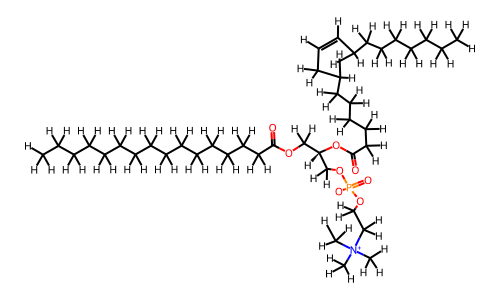

In [2]:
df = BuildLipid.load_dataframe() #load library of lipids
BuildLipid.list_available_lipids(df) #returns a list of available lipids

# Specify lipid you would like to parameterize "headgroup"+"tailgroup"
Lipid = 'POPC'

lipid_smiles, HG_pull_atom = BuildLipid.makeLipidSmiles(Lipid, df)
lipid = Molecule.from_smiles(lipid_smiles)
lipid.generate_conformers()
lipid.visualize()

In [3]:
# Assign partial charges via OpenFF NAGL
lipid.assign_partial_charges("openff-gnn-am1bcc-0.1.0-rc.2.pt", toolkit_registry=NAGLToolkitWrapper())
lipid.partial_charges


lipid.name = Lipid
for i, atom in enumerate(lipid.atoms, 0):
    atom.metadata["residue_name"] = Lipid
lipid.generate_unique_atom_names() 
topology = Topology.from_molecules([lipid])

# Specify forcefield
forcefield = ForceField("openff-2.1.0.offxml")

interchange = Interchange.from_smirnoff(
    force_field=forcefield,
    topology=topology,
    charge_from_molecules = [lipid]
)
interchange  #if using HMR, 

lipid.to_file('lipid.pdb', file_format = 'pdb')
interchange.to_top("lipid.top")
interchange.to_gro("lipid.gro")

/home/julianne/miniconda3/envs/openff_clone/lib/python3.11/site-packages/openff/interchange/interop/gromacs/export/_export.py:48: UserWarning: WARNING: System defined with no box vectors, which GROMACS does not offically support in versions 2020 or newer (see https://gitlab.com/gromacs/gromacs/-/issues/3526). Setting box vectors to a 5  nm cube.
  self._write_gro(gro, decimal)


In [4]:
view = nglview.show_structure_file('lipid.pdb')
view

NGLWidget()

In [5]:
water_model = 'TIP3P'
water = Molecule.from_smiles('O')
water.generate_conformers()
water.name = water_model

for i, atom in enumerate(water.atoms, 3):
    atom.metadata["residue_name"] = water_model
water.generate_unique_atom_names() 
topology = Topology.from_molecules([water])


interchange = Interchange.from_smirnoff(
    force_field=forcefield,
    topology=topology,
)
interchange

# PDB structure for Packmol
interchange.to_pdb("water.pdb")

In [6]:
pullLipid('lipid.gro', 'lipid.top',HG_pull_atom)

                     :-) GROMACS - gmx make_ndx, 2023.1 (-:

Executable:   /home/julianne/pkgs/gromacs-2023.1/bin/gmx
Data prefix:  /home/julianne/pkgs/gromacs-2023.1
Working dir:  /media/julianne/DATA/Lipids/OpenFFLipid/Workflow
Command line:
  gmx make_ndx -f lipid.gro -o N1x.ndx


Reading structure file

Back Off! I just backed up N1x.ndx to ./#N1x.ndx.1#

GROMACS reminds you: "We will always have STEM with us. Some things will drop out of the public eye and will go away, but there will always be science, engineering, and technology. And there will always, always be mathematics." (Katherine Johnson)

                      :-) GROMACS - gmx grompp, 2023.1 (-:

Executable:   /home/julianne/pkgs/gromacs-2023.1/bin/gmx
Data prefix:  /home/julianne/pkgs/gromacs-2023.1
Working dir:  /media/julianne/DATA/Lipids/OpenFFLipid/Workflow
Command line:
  gmx grompp -f scripts/pull.mdp -c lipid.gro -p lipid.top -n N1x.ndx -o pull.tpr -maxwarn 1

Generating 1-4 interactions: fudge = 0.5
Pull group 

Going to read 0 old index file(s)
Analysing residue names:
There are:     1      Other residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...

  0 System              :   134 atoms
  1 Other               :   134 atoms
  2 POPC                :   134 atoms

 nr : group      '!': not  'name' nr name   'splitch' nr    Enter: list groups
 'a': atom       '&': and  'del' nr         'splitres' nr   'l': list residues
 't': atom type  '|': or   'keep' nr        'splitat' nr    'h': help
 'r': residue              'res' nr         'chain' char
 "name": group             'case': case sensitive           'q': save and quit
 'ri': residue index

> 
Found 1 atoms with name N1X

> 

> 
Setting the LD random seed to -371213314

Generated 9045 of the 9045 non-bonded parameter combinations

Generated 9045 of the 9045 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'POPC'

turning H bonds into constraints...

Setting gen_seed to 2038164


Back Off! I just backed up pull.xtc to ./#pull.xtc.1#

Back Off! I just backed up pull.edr to ./#pull.edr.1#
starting mdrun 'FOO'
50000 steps,    100.0 ps.


Note that major changes are planned in future for editconf, to improve usability and utility.
Read 134 atoms
Volume: 125 nm^3, corresponds to roughly 56200 electrons
Velocities found



Writing final coordinates.

Back Off! I just backed up pull.gro to ./#pull.gro.1#

               Core t (s)   Wall t (s)        (%)
       Time:      505.679       31.605     1600.0
                 (ns/day)    (hour/ns)
Performance:      273.378        0.088

GROMACS reminds you: "Never mind, death professor, your structure's fine" (TV on the Radio)

                     :-) GROMACS - gmx editconf, 2023.1 (-:

Executable:   /home/julianne/pkgs/gromacs-2023.1/bin/gmx
Data prefix:  /home/julianne/pkgs/gromacs-2023.1
Working dir:  /media/julianne/DATA/Lipids/OpenFFLipid/Workflow
Command line:
  gmx editconf -f pull.gro -o pulled_lipid.pdb


GROMACS reminds you: "Never mind, death professor, your structure's fine" (TV on the Radio)



### Use trjconv to produce a pdb of the lipid after pull code. Visualize with nglview to confirm 


In [8]:
#visualize the pulled lipid using ngl view
view = nglview.show_structure_file('pulled_lipid.pdb')
view


NGLWidget()

### Run packmol with the dumped PDB

Is there a good way to do this? Look into openff pack box module to see if that can be adapted for lipids? Otherwise this may be difficult

In [ ]:
u = mda.Universe('POPE.pdb')

head_group = u.select_atoms('name N1x') #select atom in head group, in this case Nitrogen
tail_group = u.select_atoms('name C28x') #select atom in tail group, in this case last carbon in unsaturated tail

distance = distances.distance_array(head_group.positions,tail_group.positions)
print("Length of lipid from head group to tail group is:\n","~",round(distance[0][0],2),'Angstrom') 
#this will tell you the full length of your lipid 


Estimate the desired number of lipids or membrane size in x y diresction when area per lipid is roughly known \
$ N_I = \frac{2 L_x L_y}{a_I}$  \
where $N_I$ = total # lipids\
$L_x , L_y$ = lateral box dimensions\
$a_I$ = area per lipid in units $Å^{2}$

In [ ]:
# POPC ~ 65 Å^2
#For a square box:
N = 128
a = 65
L = np.sqrt(N * a /2)
print(round(L,1), "angstrom dimensions for Length")

In [ ]:
#modify .inp file if necessary with propper length and atom names 
$ packmol < bilayer-comment.inp
#if you have errors after running packmol make your box bigger 
# this returns a bilayer.pdb file that can be visualized below 

In [ ]:
model_path = '/home/julianne/Desktop/Run_feb8/Compressed/bilayer.pdb' #change model path

view = nglview.show_structure_file(model_path)
view

### Build topology file from system interchange and get .gro file from .pdb

In [ ]:
topology = Topology.from_molecules(5120 * [water] + 128 * [lipid])

# Packmol bilayer to parametrize
path = mdtraj.load('bilayer.pdb')

# Topology designation given Packmol coordinates
topology.set_positions(path.xyz[0] * unit.nanometer)
topology.box_vectors = [8.0,8.0,9.8] * unit.nanometer

water.name = "TIP3P"
lipid.name = "POPC"


# for i, atom in enumerate(lipid.atoms, 3):
#     atom.metadata["residue_name"] = "POPC"
#     lipid.generate_conformers()
#     lipid.generate_unique_atom_names() #(suffix = "x") this suffix is default 
# for i, atom in enumerate(water.atoms, 3):
#     atom.metadata["residue_name"] = "TIP3P"
#     water.generate_conformers()
#     water.generate_unique_atom_names() #(suffix = "w")

interchange = forcefield.create_interchange(topology)

interchange.to_gromacs(prefix = "bilayer")

In [ ]:
# Do you want to add ions?

# gmx grompp -f ions.mdp -c bilayer.gro -p topol.top -o ions.tpr
# gmx genion -s ions.tpr -o bilayer_ions.gro -p topol.top -pname NA -nname CL -neutral\

# When prompted, choose group TIP3P (group 2) for embedding ions. You do not want to replace parts of your protein with ions

Files are now ready to be run using Gromacs.

Min, NVT, NPT, MD production run

In [ ]:
$ gmx grompp -f min.mdp -p topol.top -c bilayer.gro -o min.tpr
$ gmx mdrun -deffnm min

$ gmx grompp -p topol.top -f nvt.mdp -c min.gro -o nvt.tpr
$ gmx mdrun -deffnm nvt

$ gmx grompp -f npt.mdp -p topol.top -c nvt.gro -o npt.tpr -maxwarn 1
$ gmx mdrun -deffnm npt

$ gmx grompp -f md.mdp -c npt.gro -t npt.cpt -p topol.top -o md.tpr
$ gmx mdrun -deffnm md
# Checkpoint run for completion
$ gmx mdrun -deffnm md -cpi md.cpt